# Homework nr. 3 - features transformation & selection (deadline 13/12/2018)

In short, the main task is to play with transformations and feature selection methods in order to obtain the best results for linear regression model predicting house sale prices.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (=our prediction model) of the observed sale prices.

### Instructions:

  1. Download the dataset from the course pages (hw3_data.csv, hw3_data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
  2. Split the dataset into train & test part exactly as we did in the tutorial.
  3. Transform the features properly (don't forget the target variable).
  4. Try to find the best subset of features.
  5. Compare your results with the [Kaggle leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard). You should be able to reach approximately the top 20% there.
  
Give comments on each step of your solution, with short explanations of your choices.

  
**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [41]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [42]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [43]:
# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')
# Fill all NaN with 0
df.loc[:,df.select_dtypes(include=['float64']).columns] = df.loc[:,df.select_dtypes(include=['float64']).columns].fillna(0)

In [44]:
df.columns[df.isnull().any()]

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [45]:
# Convert categorical variables to indicators and create new data
df = pd.get_dummies(df)

# check that there are no missings now
print(df.isnull().any().any())

False


In [46]:
df[df.select_dtypes(['float16', 'float64', 'int64']).columns] = df[df.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')

In [47]:
# Let us create new features as square roots of Area features - i.e. so they correspond to diameters of circles having the same area
# We also add indicators of zero values (usually missings) there
for column in df.filter(regex='Area|SF', axis=1).columns:  # SF - square foot which means area
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    df['Sqrt' + column] = np.sqrt(df[column])

In [48]:
# Remove constant features
display(df.columns[df.min() == df.max()])
df = df[df.columns[df.min() != df.max()]]

Index(['HasLotArea', 'Has1stFlrSF', 'HasGrLivArea'], dtype='object')

C:\Users\Joris\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


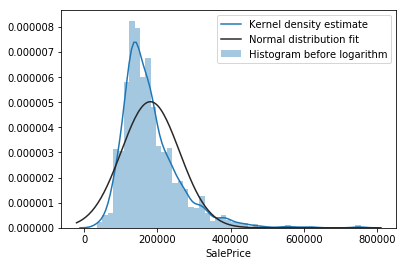

In [49]:
#display(df.SalePrice)
sns.distplot(df['SalePrice'], 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram before logarithm'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )
plt.legend()
#Calculate logarithm of SalePrice to create better distribution
df['SalePrice'] = np.log(df['SalePrice'])

#sns.distplot(df.SalePrice, 
#             fit=stats.norm) 



C:\Users\Joris\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


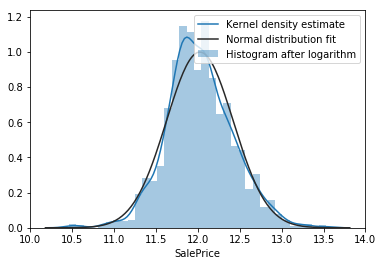

In [50]:
#Visualize distribution after calculating logarithm of SalePrice
sns.distplot(df.SalePrice, 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram after logarithm'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )
plt.legend()

In [51]:
dt, dv = model_selection.train_test_split(df, test_size=0.25, random_state=17)
dt = dt.copy()
dv = dv.copy()

In [52]:
def linreg(train, validate, plot = False, train_error = True):
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice
    
    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    
    # Print RMSE
    print('Linear regression root mean squared validation error:', 
          np.sqrt(metrics.mean_squared_error(clf.predict(Xv),yv)))
    if train_error:
        print('Linear regression root mean squared train error:', 
              np.sqrt(metrics.mean_squared_error(clf.predict(X), y)))
    
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))

In [123]:
# Run both models
linreg(dt, dv)


Linear regression root mean squared validation error: 0.12473817989273199
Linear regression root mean squared train error: 0.08449981372604107


In [124]:
# Standardization
standard_scaler = preprocessing.StandardScaler()

# we rescale only numeric values - not indicators
columns = dt.select_dtypes(include=['float64']).columns 
columns = columns.drop('SalePrice', errors = 'ignore')

# Prepare values for the transformation
standard_scaler.fit(dt[columns])

# Transform of both train and validation
# Standardization
dt_s = dt.copy()
dv_s = dv.copy()
dt_s[columns] = standard_scaler.transform(dt[columns])
dv_s[columns] = standard_scaler.transform(dv[columns])

In [125]:
print('Standardized data')
linreg(dt_s, dv_s)

Standardized data
Linear regression root mean squared validation error: 2990145342.1335335
Linear regression root mean squared train error: 0.0879696544227162


In [126]:
# Drop Id - we will store all features to drop in the columns_to_remove list
columns_to_remove = ['Id']

# Find features with low variance - we assume that they cannot help to infer the observable
# this makes sense especially for indicators
columns_to_remove = list(set(list(dt_s.columns[dt_s.var() < 0.01]) + columns_to_remove))

# Correlation matrix Pearson & Spearman
corrP = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='spearman')

# One can remove those with correlation smaller than some treshold.
additional_columns = list(corrP.SalePrice[corrP.SalePrice.abs() < 0.001].index)

# extend columns_to_remove
columns_to_remove = list(set(columns_to_remove + additional_columns))

# Alternatively, if we don't want to set a treshold in correlation values (we don't know what value to choose)
# we can do the analogous selection based on p-values of statistical test about the zero correlation

# prepare data
X = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

# calculate F values for correlation coefficient (calculated from rho using an increasing function)
# calculate p-values of the correspondong F-test (inversely proportional to rho)
Fscores, pvals = feature_selection.f_regression(X,y)
pvals_result = pd.Series(pvals, index = X.columns)

# One can remove those with p-value smaller than some treshold.
additional_columns = list(pvals_result[pvals_result > 0.8].index)

# extend columns_to_remove
columns_to_remove = list(set(columns_to_remove + additional_columns))

# Perform t-test with indicator variables - calculate p-values
ttest_pvals = df\
    .drop(columns_to_remove, axis = 1, errors = 'ignore')\
    .select_dtypes(include = ['uint8']).columns\
    .to_series()\
    .apply(lambda x: stats.ttest_ind(df.SalePrice[df[x] == 0], df.SalePrice[df[x] == 1], equal_var = False).pvalue)

# Remove all larger than 50%
columns_to_remove = list(set(columns_to_remove + list(ttest_pvals[ttest_pvals > 0.6].index)))

# Final removal from all datasets
dt.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)

In [127]:
# Run both models, now in the top 18 Percent.
linreg(dt, dv)

Linear regression root mean squared validation error: 0.11979703753347867
Linear regression root mean squared train error: 0.09418184357428976
